---
title: "trend test"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


How to determine if there is a trend (positive or negative) between two variables?

In [1]:
#| code-summary: "import libraries"
import numpy as np
from scipy.stats import linregress
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)

Text(0, 0.5, 'Y')

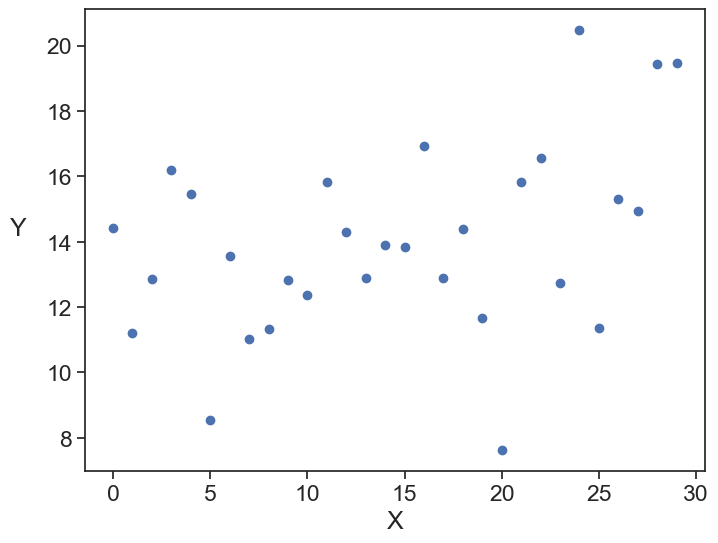

In [2]:
#| code-summary: "generate data and plot"
np.random.seed(0) # for reproducibility
x = np.arange(30)
y = (0.2 * x) + 10 + np.random.normal(loc=0, scale=2.5, size=30)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y)
ax.set(xlabel='X')
ax.set_ylabel('Y', rotation=0, labelpad=20)

## linear regression

One of the simplest ways to determine if there is a trend between two variables is to use linear regression. 

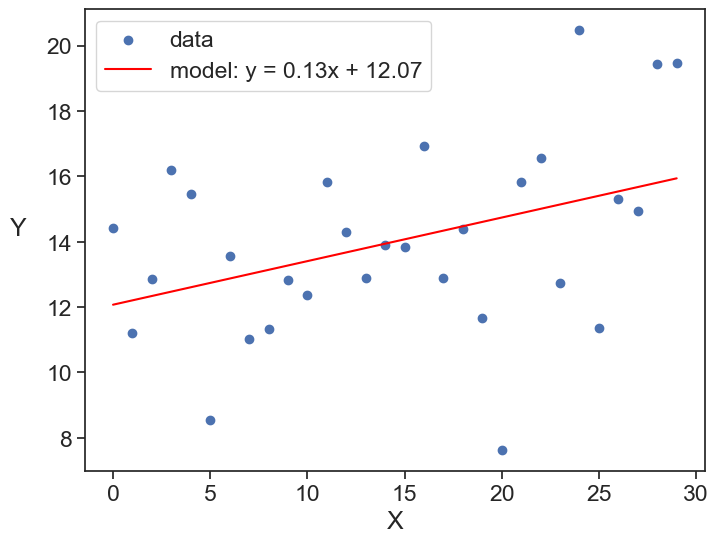

In [3]:
#| code-summary: "fit linear model and plot"
slope, intercept, _, _, _ = linregress(x, y)
y_hat = slope * x + intercept

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, label='data')
ax.plot(x, y_hat, color='red', label=f'model: y = {slope:.2f}x + {intercept:.2f}')
ax.set(xlabel='X')
ax.set_ylabel('Y', rotation=0, labelpad=20)
ax.legend()

Great, we found that there is a positive slope, its value is 0.13. It this enough to say that there is a trend? 

We need to determine if the slope is significantly different from zero. For that we can use a t-test.

**Null Hypothesis:** The slope is equal to zero (no trend).  
**Alternative Hypothesis:** The slope is not equal to zero (there is a trend).

The t-statistic is calculated as:

$$
t = \frac{\text{slope} - 0}{SE_\text{slope}},
$$

where $SE_\text{slope}$ is the standard error of the slope, and it is given by:

$$
SE_\text{slope} = \frac{SD_\text{residuals}}{\sqrt{\sum (x_i - \bar{x})^2}}.
$$

where $SD_\text{residuals}$ is the standard deviation of the residuals, $x_i$ are the individual $x$ values, and $\bar{x}$ is the mean of the $x$ values.

The standard deviation of the residuals is calculated as:

$$
SD_\text{residuals} = \sqrt{\frac{\sum (y_i - \hat{y}_i)^2}{n - 2}},
$$

where $y_i$ are the observed y values, $\hat{y}_i$ are the predicted y values from the regression, and $n$ is the number of data points. The number of the degrees of freedom is $n - 2$ because we are estimating two parameters (the slope and the intercept) from the data.

Let's compute $SE_\text{slope}$, the t-statistic, and the p-value for our example.

In [4]:
#| code-summary: "manual computation vs scipy"
# calculate the residuals
residuals = y - y_hat
# calculate the sum of squared residuals (SSR)
sum_squared_residuals = np.sum(residuals**2)
# calculate the Residual Standard Error (s_e)
n = len(x)
degrees_of_freedom = n - 2
residual_std_error = np.sqrt(sum_squared_residuals / degrees_of_freedom)
# calculate the sum of squared deviations of x from its mean
x_mean = np.mean(x)
sum_squared_x_deviations = np.sum((x - x_mean)**2)
# put it all together to get SE_slope
# SE_slope = (typical error) / (spread of x)
SE_slope = residual_std_error / np.sqrt(sum_squared_x_deviations)
# verify the result against the value directly from scipy
scipy_slope, scipy_intercept, scipy_r, scipy_p, scipy_se = linregress(x, y)
print(f"manually calculated SE_slope:          {SE_slope:.6f}")
print(f"SE_slope from scipy.stats.linregress:  {scipy_se:.6f}")

manually calculated SE_slope:          0.057695
SE_slope from scipy.stats.linregress:  0.057695


In [5]:
#| code-summary: "calculate p-value manually"
t_statistic = (slope-0) / SE_slope
p_value = 2 * (1 - scipy.stats.t.cdf(np.abs(t_statistic), df=degrees_of_freedom))
print(f"manually calculated p-value: {p_value:.6f}")
print(f'scipy p-value:               {scipy_p:.6f}')

manually calculated p-value: 0.028344
scipy p-value:               0.028344


If we choose a significance level $\alpha=0.05$, the p-value we found indicates that we can reject the null hypothesis and conclude that there is a significant trend between x and y.

If instead of testing if the slope is different from zero, but rather if it is greater than zero (i.e., a one-sided test), we would divide the p-value by 2.

In [6]:
#| code-summary: "one-sided p-value"
p_value = (1 - scipy.stats.t.cdf(np.abs(t_statistic), df=degrees_of_freedom))
scipy_slope, scipy_intercept, scipy_r, scipy_p, scipy_se = linregress(x, y, alternative='greater')
print(f"manually calculated p-value: {p_value:.6f}")
print(f'scipy p-value:               {scipy_p:.6f}')

manually calculated p-value: 0.014172
scipy p-value:               0.014172


One last remark. What does the formula for the standard error of the slope mean?

* inside the square root, we have a quantity dependent on y squared divided by a quantity dependent on x squared. Dimensionally this makes sense, because the standard error of the slope should have the same dimension as the slope $\Delta y/\Delta x$.
* the larger the variability of the residuals (i.e., the more scattered the data points are around the regression line), the larger the standard error of the slope, and thus the less precise our estimate of the slope is.
* We can [manipulate the formula](https://stats.stackexchange.com/a/342672){target="_blank"} a little bit to get more intuition:
  $$
    SE_\text{slope} = \sqrt{\frac{1}{n-2}}\frac{SD_y}{SD_x}\sqrt{1-r^2},
  $$
  where $SD_y$ and $SD_x$ are the standard deviations of y and x, respectively, and $r$ is the correlation coefficient between $x$ and $y$. From this formula we can see that:
    a) the standard error of the slope decreases with increasing sample size $n$ (more data points lead to a more precise estimate of the slope);
    b) imagine all the data points in a rectangular box, and all the possible slopes that can be drawn within that box. If you change the dimensions of the box, you need to account for that, and that is the second term.
    c) The last term acounts for the spread of the points about the line.

## Mann-Kendall Trend Test

The method above assumed that the relationship between x and y is linear, and that the residuals are normally distributed. If these assumptions are not met, we can use a non-parametric test like the Mann-Kendall trend test. The intuition behind this test works like a voting system. You go through your data and compare every data point to all points that come after it.

* if a later points is higher, you give a +1 vote
* if a later point is lower, you give a -1 vote
* if they are equal, you give a 0 vote

All these votes are summed up. A large positive sum indicates an increasing trend, a large negative sum indicates a decreasing trend, and a sum close to zero indicates no trend.
We can then calculate a test statistic $Z$ based on the sum of votes, and use it to determine the p-value. If the p-value is less than our chosen significance level (e.g., 0.05), we can reject the null hypothesis of no trend. We can use the package [`pymannkendall`](https://pypi.org/project/pymannkendall/) to perform the Mann-Kendall trend test.

In [7]:
#| code-summary: "applying the Mann-Kendall test"
from pymannkendall import original_test
mk_result = original_test(y)
print(mk_result)

Mann_Kendall_Test(trend='increasing', h=True, p=0.04970274086760851, z=1.9625134103851736, Tau=0.25517241379310346, s=111.0, var_s=3141.6666666666665, slope=0.14036402565970577, intercept=11.836643578083883)


The test concluded that there is an increasing trend, with a p-value of 0.0497.

## Spearman's Rank Correlation

This is another non-parametric test. It assesses how well the relationship between two variables can be described using a monotonic function. It does this by converting the data to ranks and then calculating the Pearson correlation coefficient on the ranks. The Spearman's rank correlation coefficient, denoted by $\rho$ (rho), ranges from -1 to 1, where:

* 1 indicates a perfect positive **monotonic** relationship,
* -1 indicates a perfect negative **monotonic** relationship,
* 0 indicates no monotonic relationship.

This test is robust to outliers and does not assume a linear relationship between the variables.

We can use the `scipy.stats.spearmanr` function to calculate Spearman's rank correlation coefficient and the associated p-value.

In [9]:
#| code-summary: "applying the Spearman's Rank Correlation test"
spearman_corr, spearman_p = scipy.stats.spearmanr(x, y)
print(f"Spearman's correlation: {spearman_corr:.6f}, p-value: {spearman_p:.6f}")

Spearman's correlation: 0.361958, p-value: 0.049356


We found that there is a positive monotonic relationship between x and y, with a p-value of 0.0494, indicating that the relationship is statistically significant at the 0.05 significance level.

## Theil-Sen Estimator

The Theil-Sen estimator is a robust method for estimating the slope of a linear trend. It is particularly useful when the data contains outliers or is not normally distributed. The Theil-Sen estimator calculates the slope as the median of all possible pairwise slopes between data points.
We can use the `scipy.stats.theilslopes` function to calculate the Theil-Sen estimator and the associated confidence intervals.

In [10]:
#| code-summary: "applying the Theil-Sen Estimator"
from scipy.stats import theilslopes
theil_slope, theil_intercept, theil_lower, theil_upper = theilslopes(y, x, 0.95)
print(f"Theil-Sen slope: {theil_slope:.6f}, intercept: {theil_intercept:.6f}")

Theil-Sen slope: 0.140364, intercept: 11.836644
